In [22]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR


In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
sns.set(style="whitegrid")

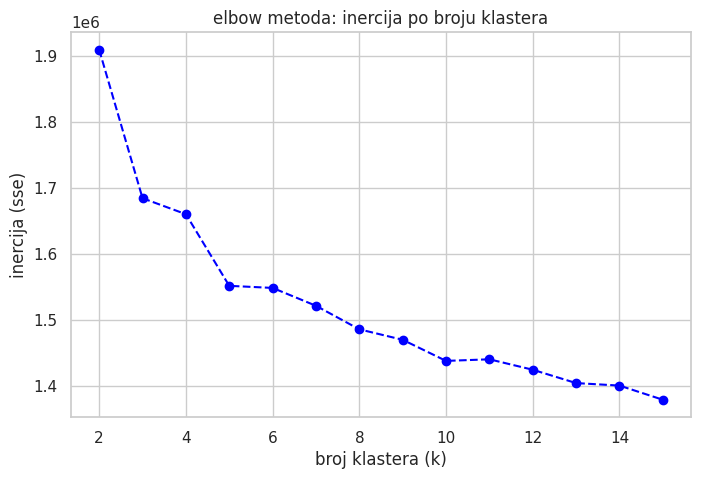

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(ks, inercije, marker="o", linestyle="--", color="blue")
plt.xlabel("broj klastera (k)")
plt.ylabel("inercija (sse)")
plt.title("elbow metoda: inercija po broju klastera")
plt.show()

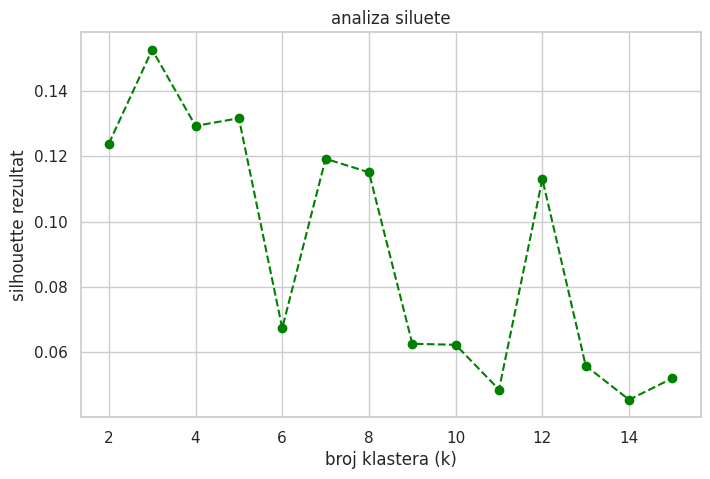

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(ks, siluete, marker="o", linestyle="--", color="green")
plt.xlabel("broj klastera (k)")
plt.ylabel("silhouette rezultat")
plt.title("analiza siluete")
plt.show()

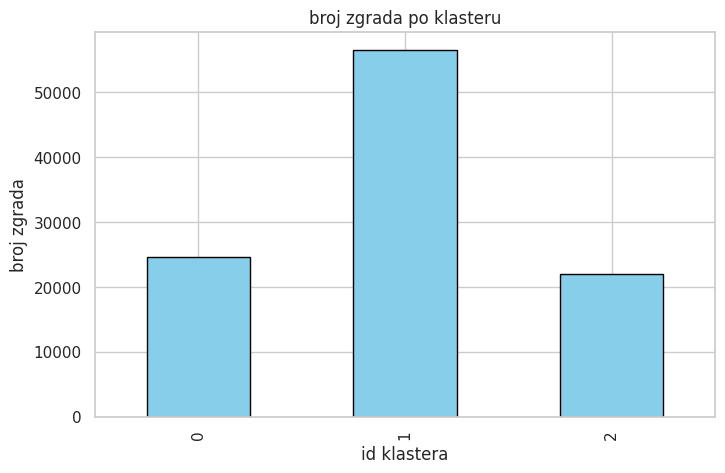

In [34]:
plt.figure(figsize=(8, 5))
counts = podskup["klaster"].value_counts().sort_index()
counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("id klastera")
plt.ylabel("broj zgrada")
plt.title("broj zgrada po klasteru")
plt.show()

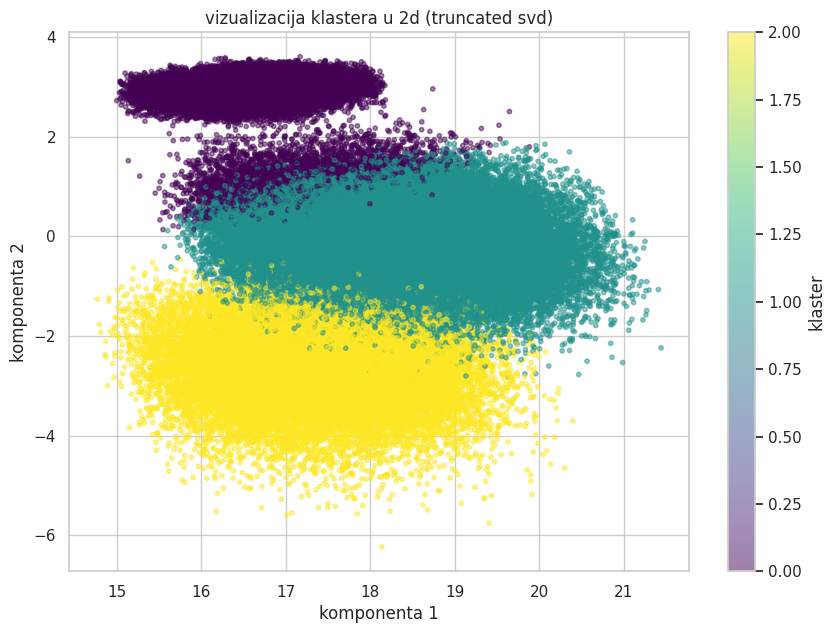

In [23]:
def odredi_stupce(tablica):
    kategorijske = tablica.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    numericke = [c for c in tablica.columns if c not in kategorijske]
    return numericke, kategorijske

def napravi_pretproces(numericke, kategorijske):
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler(with_mean=False)),
            ]), numericke),
            ("kat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", ohe),
            ]), kategorijske),
        ],
        sparse_threshold=0.3,
    )


In [24]:
putanja_podataka = "urban_building_stock_datasets.csv"
udio = 0.10
sjeme = 42

podaci = pd.read_csv(putanja_podataka)
podskup = podaci.sample(frac=udio, random_state=sjeme).reset_index(drop=True)

print(f"ucitano 10 posto: {podskup.shape[0]} redaka, {podskup.shape[1]} stupaca")


ucitano 10 posto: 103002 redaka, 32 stupaca


In [25]:
ishodi_energije = [
    "Heating_Usage",
    "Water_Systems_Energy",
    "Interior_Lighting_Energy",
    "Interior_Equipment_Energy",
    "Total_Heating_Energy",
    "Photovoltaic_Power",
    "Total_Electricity_Energy",
    "Energy_Use_Intensity",
]

cilj = "Energy_Use_Intensity"
if cilj not in podskup.columns:
    raise ValueError("ciljni stupac nije pronaden: energy_use_intensity")

znacajke = [c for c in podskup.columns if c not in ishodi_energije]
x_klaster = podskup[znacajke].copy()

numericke, kategorijske = odredi_stupce(x_klaster)
pretproces = napravi_pretproces(numericke, kategorijske)
x_matrica = pretproces.fit_transform(x_klaster)

print(f"broj znacajki (prije kodiranja): {len(znacajke)}")


broj znacajki (prije kodiranja): 24


In [26]:
ks = range(2, 16)
inercije = []
siluete = []

for k in ks:
    model = MiniBatchKMeans(
        n_clusters=k,
        random_state=sjeme,
        n_init=10,
        batch_size=8192,
        max_iter=200,
    )
    oznake = model.fit_predict(x_matrica)
    sil = silhouette_score(
        x_matrica,
        oznake,
        sample_size=min(5000, x_matrica.shape[0]),
        random_state=sjeme,
    )
    inercije.append(model.inertia_)
    siluete.append(sil)
    print(f"k={k} inertia={model.inertia_:.2f} silhouette={sil:.4f}")

najbolji_k = int(list(ks)[int(np.argmax(siluete))])
print(f"odabrani optimalni k: {najbolji_k}")


k=2 inertia=1910017.53 silhouette=0.1239
k=3 inertia=1684559.89 silhouette=0.1526
k=4 inertia=1660320.62 silhouette=0.1293
k=5 inertia=1551534.93 silhouette=0.1317
k=6 inertia=1548369.93 silhouette=0.0674
k=7 inertia=1521259.43 silhouette=0.1193
k=8 inertia=1485498.86 silhouette=0.1151
k=9 inertia=1469605.54 silhouette=0.0626
k=10 inertia=1437555.58 silhouette=0.0623
k=11 inertia=1439974.52 silhouette=0.0486
k=12 inertia=1424121.10 silhouette=0.1130
k=13 inertia=1403865.07 silhouette=0.0559
k=14 inertia=1400074.84 silhouette=0.0455
k=15 inertia=1378557.06 silhouette=0.0521
odabrani optimalni k: 3


In [27]:
model_klastera = MiniBatchKMeans(
    n_clusters=najbolji_k,
    random_state=sjeme,
    n_init=10,
    batch_size=8192,
    max_iter=500,
)
podskup["klaster"] = model_klastera.fit_predict(x_matrica)

velicine = podskup["klaster"].value_counts()
print("velicine klastera:")
for i, v in velicine.sort_index().items():
    print(f"klaster {i}: {v}")

najveci_klaster_id = int(velicine.idxmax())
print(f"najveci klaster: {najveci_klaster_id} (n={int(velicine.max())})")


velicine klastera:
klaster 0: 24569
klaster 1: 56517
klaster 2: 21916
najveci klaster: 1 (n=56517)


In [28]:
najveci_klaster = podskup[podskup["klaster"] == najveci_klaster_id].copy()

x_pred = najveci_klaster[znacajke].copy()
y_pred = najveci_klaster[cilj].copy()

x_trening, x_test, y_trening, y_test = train_test_split(
    x_pred, y_pred, test_size=0.2, random_state=sjeme
)

numericke_p, kategorijske_p = odredi_stupce(x_trening)
pretproces_p = napravi_pretproces(numericke_p, kategorijske_p)

model_potrosnje = Pipeline([
    ("pretproces", pretproces_p),
    ("model", SVR(kernel="rbf", C=10.0, epsilon=0.1)),
])

model_potrosnje.fit(x_trening, y_trening)
predikcije = model_potrosnje.predict(x_test)

mae = mean_absolute_error(y_test, predikcije)
rmse = mean_squared_error(y_test, predikcije)
r2 = r2_score(y_test, predikcije)

print("rezultati predikcije na najvecom klasteru:")
print(f"mae={mae:.4f}")
print(f"rmse={rmse:.4f}")
print(f"r2={r2:.4f}")


rezultati predikcije na najvecom klasteru:
mae=11.2926
rmse=353.5598
r2=0.9652


In [29]:
mse = mean_squared_error(y_test, predikcije)
rmse = float(np.sqrt(mse))
mae = mean_absolute_error(y_test, predikcije)
r2 = r2_score(y_test, predikcije)

print("rezultati predikcije na najvecom klasteru:")
print(f"mae={mae:.4f}")
print(f"rmse={rmse:.4f}")
print(f"r2={r2:.4f}")


rezultati predikcije na najvecom klasteru:
mae=11.2926
rmse=18.8032
r2=0.9652


In [30]:
izlaz_klasteri = "podskup_10_posto_klasteri.csv"
izlaz_najveci = "najveci_klaster.csv"

podskup.to_csv(izlaz_klasteri, index=False)
najveci_klaster.to_csv(izlaz_najveci, index=False)

print(f"spremljeno: {izlaz_klasteri}")
print(f"spremljeno: {izlaz_najveci}")


spremljeno: podskup_10_posto_klasteri.csv
spremljeno: najveci_klaster.csv


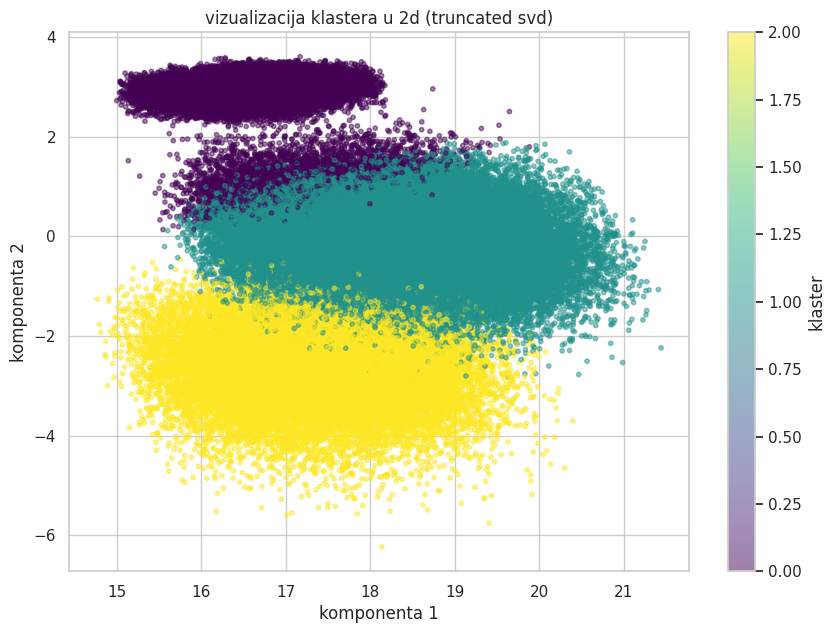

In [37]:

svd = TruncatedSVD(n_components=2, random_state=sjeme)
x_2d = svd.fit_transform(x_matrica)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=podskup["klaster"], cmap="viridis", alpha=0.5, s=10)
plt.colorbar(scatter, label="klaster")
plt.title("vizualizacija klastera u 2d (truncated svd)")
plt.xlabel("komponenta 1")
plt.ylabel("komponenta 2")
plt.show()

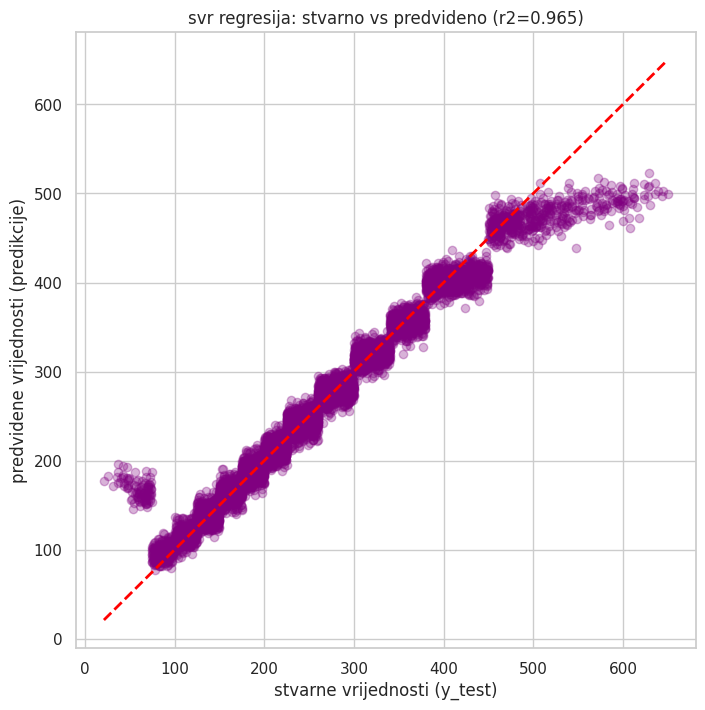

In [36]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predikcije, alpha=0.3, color="purple")

min_val = min(y_test.min(), predikcije.min())
max_val = max(y_test.max(), predikcije.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", lw=2)

plt.xlabel("stvarne vrijednosti (y_test)")
plt.ylabel("predvidene vrijednosti (predikcije)")
plt.title(f"svr regresija: stvarno vs predvideno (r2={r2:.3f})")
plt.show()